# 开卷有益

从爬虫练习网站 http://quotes.toscrape.com 上爬取1000条名言、作者等信息。

记录并导出以下信息的数据表格
- 记录所有作者的相关信息
- 记录所有名言的相关信息
- 记录所有标签

可视化
- 可视化展示作者的用词习惯
- 可视化展示作者与标签之间的关联关系

In [3]:
! pip install scrapy "cryptography<3.4" "pyopenssl<22"

## 实现爬虫

In [8]:
import json

import scrapy


class JsonWriterPipeline:
    # your code here
     def open_spider(self, spider):
         self.file = open('quotes_P.jl', 'w')

     def close_spider(self, spider):
         self.file.close()
    
     def process_item(self, item, spider):
         line = json.dumps(item)
         self.file.write(f"{line}\n")
         return item

class QuotesSpider(scrapy.Spider):
    name = "quotes"
    
    # your code here
    def start_requests(self):
        url_template = 'https://quotes.toscrape.com/page/{}/'
        for i in range(1, 11):
            url = url_template.format(i)
            yield scrapy.Request(url, callback=self.parse)
    
    custom_settings = {
        'ITEM_PIPELINES': {
            JsonWriterPipeline: 400
        }
    }

    def parse(self, response):
        items = response.css("div.quote")
        for item in items:
            text = item.css('span.text::text').get()
            author = item.css('span small.author::text').get()
            tags = item.css('div.tags a.tag::text').getall()
            yield dict(text=text, author=author, tags=tags)

## 运行爬虫

In [10]:
from scrapy.crawler import CrawlerProcess

process = CrawlerProcess(
    {'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
)
process.crawl(QuotesSpider)
process.start()

2024-10-25 13:34:33 [scrapy.utils.log] INFO: Scrapy 2.7.1 started (bot: scrapybot)
2024-10-25 13:34:33 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.4, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 22.10.0, Python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 21.0.0 (OpenSSL 1.1.1i  8 Dec 2020), cryptography 3.3.2, Platform Windows-10-10.0.22631-SP0
2024-10-25 13:34:33 [scrapy.crawler] INFO: Overridden settings:
{'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2024-10-25 13:34:33 [py.warnings] WARNING: E:\Anaconda3\anaconda\Lib\site-packages\scrapy\utils\request.py:231: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reas

## 可视化

### 可视化展示作者的用词习惯

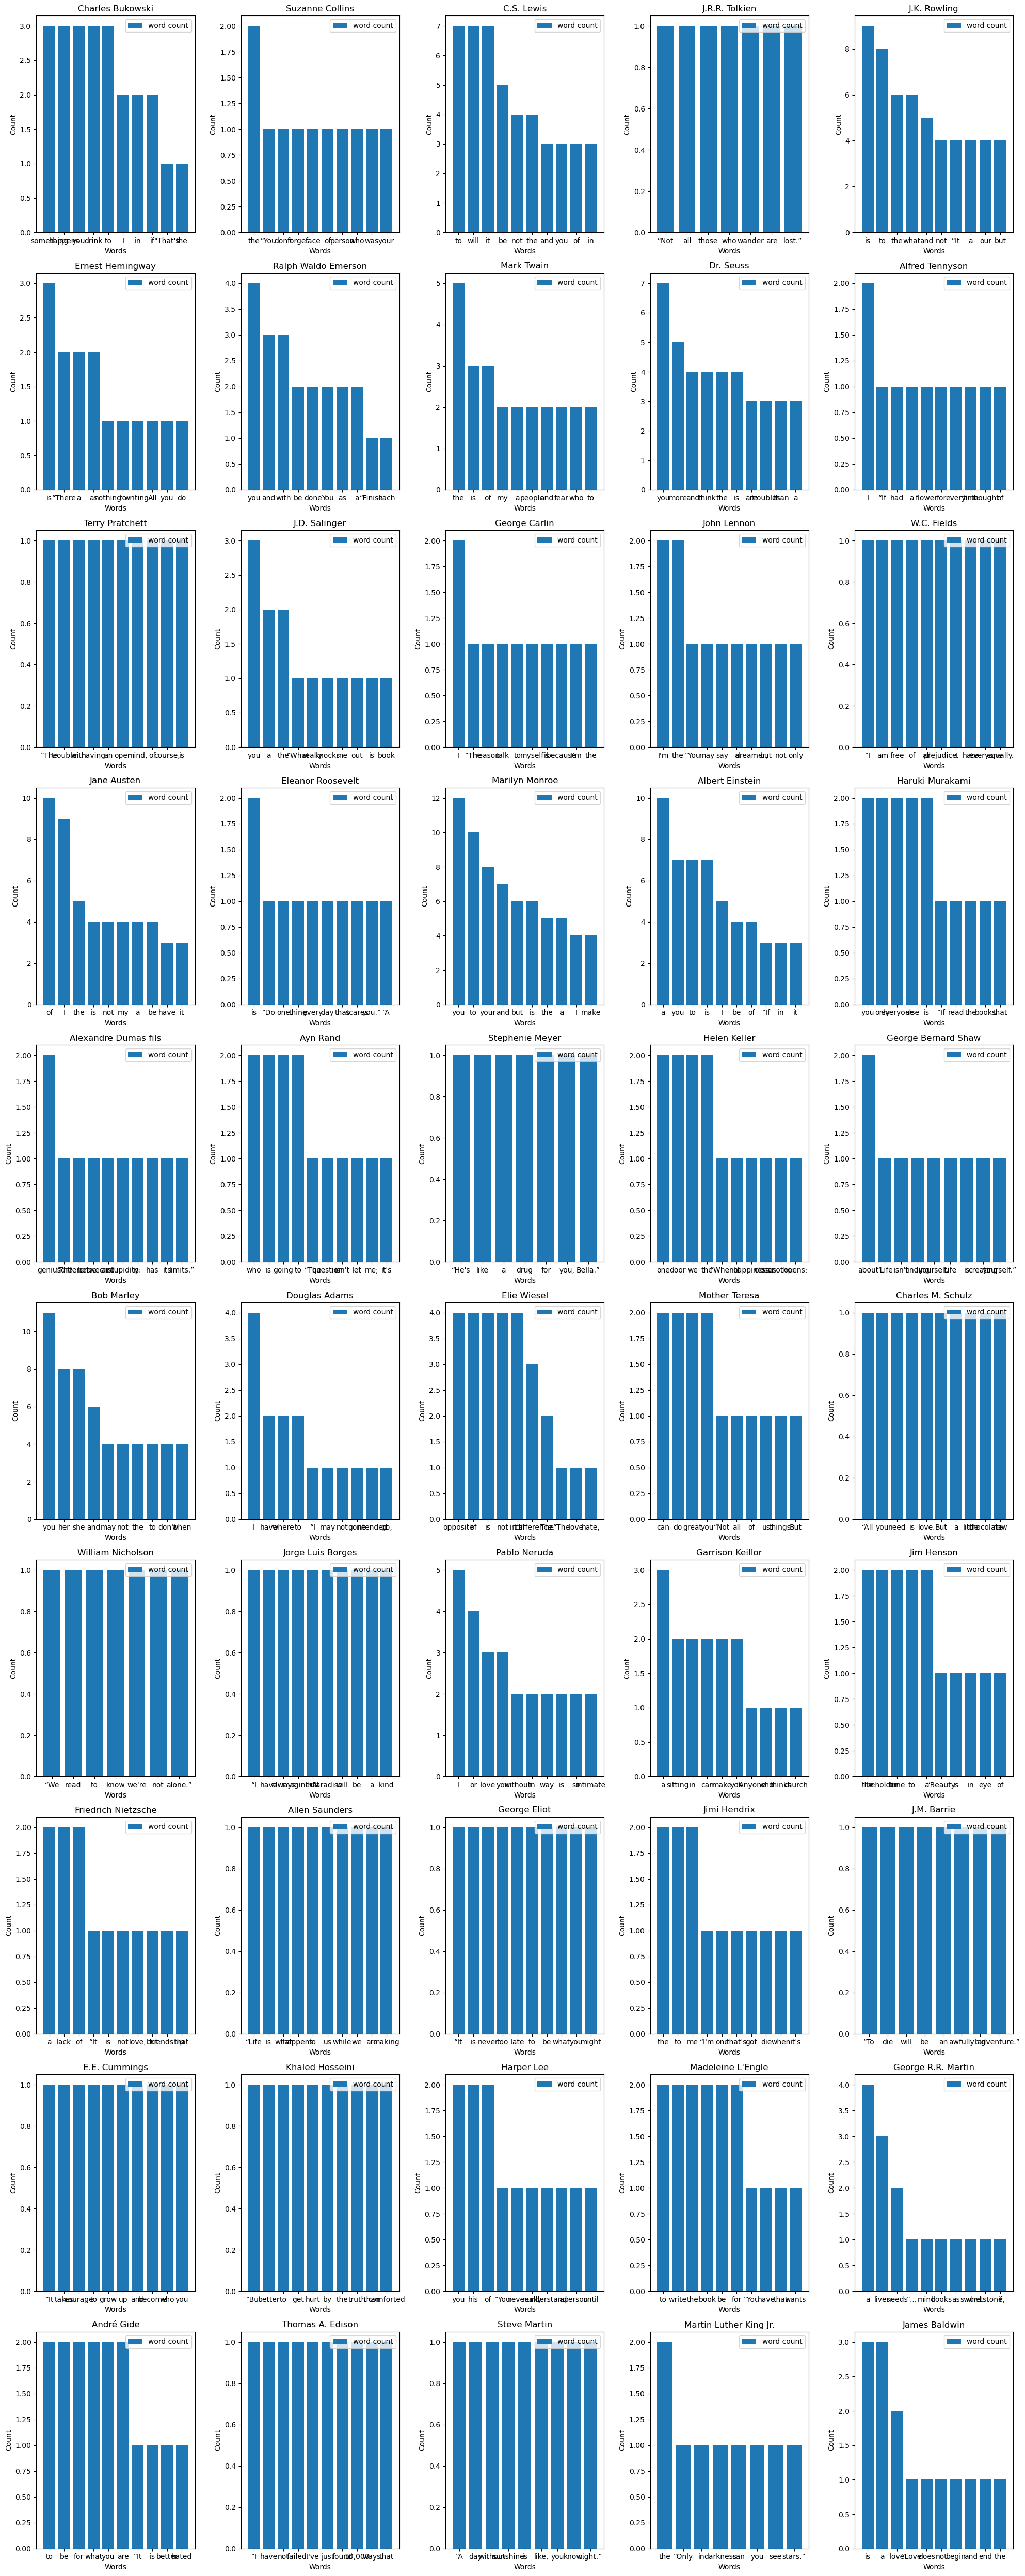

In [16]:
# read from scraped data file
# your code here
import pandas as pd
from collections import Counter

df = pd.read_json('quotes_P.jl', lines=True)
# organize the data such that corresponding words and authors are connected
# your code here
authors_quotes = {}
for i, data in df.iterrows():
    author = data.get('author')
    text = data.get('text',[])
    
    if author not in authors_quotes:
        authors_quotes[author] = [text]
    else:
        authors_quotes[author].append(text)
    
word_count = {}
for author, quotes in authors_quotes.items():
    words = ' '.join(quotes).split()
    count_words = Counter(words).most_common(10)
    word_count[author] = count_words
# visualize the data
# your code here
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 5, figsize=(20, 50))

for i, (author, words) in enumerate(word_count.items()):
    x = i // 5
    y = i % 5
    axs[x, y].bar([word for word, count in words], [count for word, count in words], label="word count")
    axs[x, y].set_title(author)
    axs[x, y].set_xticks(range(len(words)))
    axs[x, y].set_xticklabels([word for word, count in words])
    axs[x, y].set_ylabel('Count')
    axs[x, y].set_xlabel('Words')
    axs[x, y].legend()

plt.tight_layout()
plt.show()

## 可视化展示作者与标签之间的关联关系

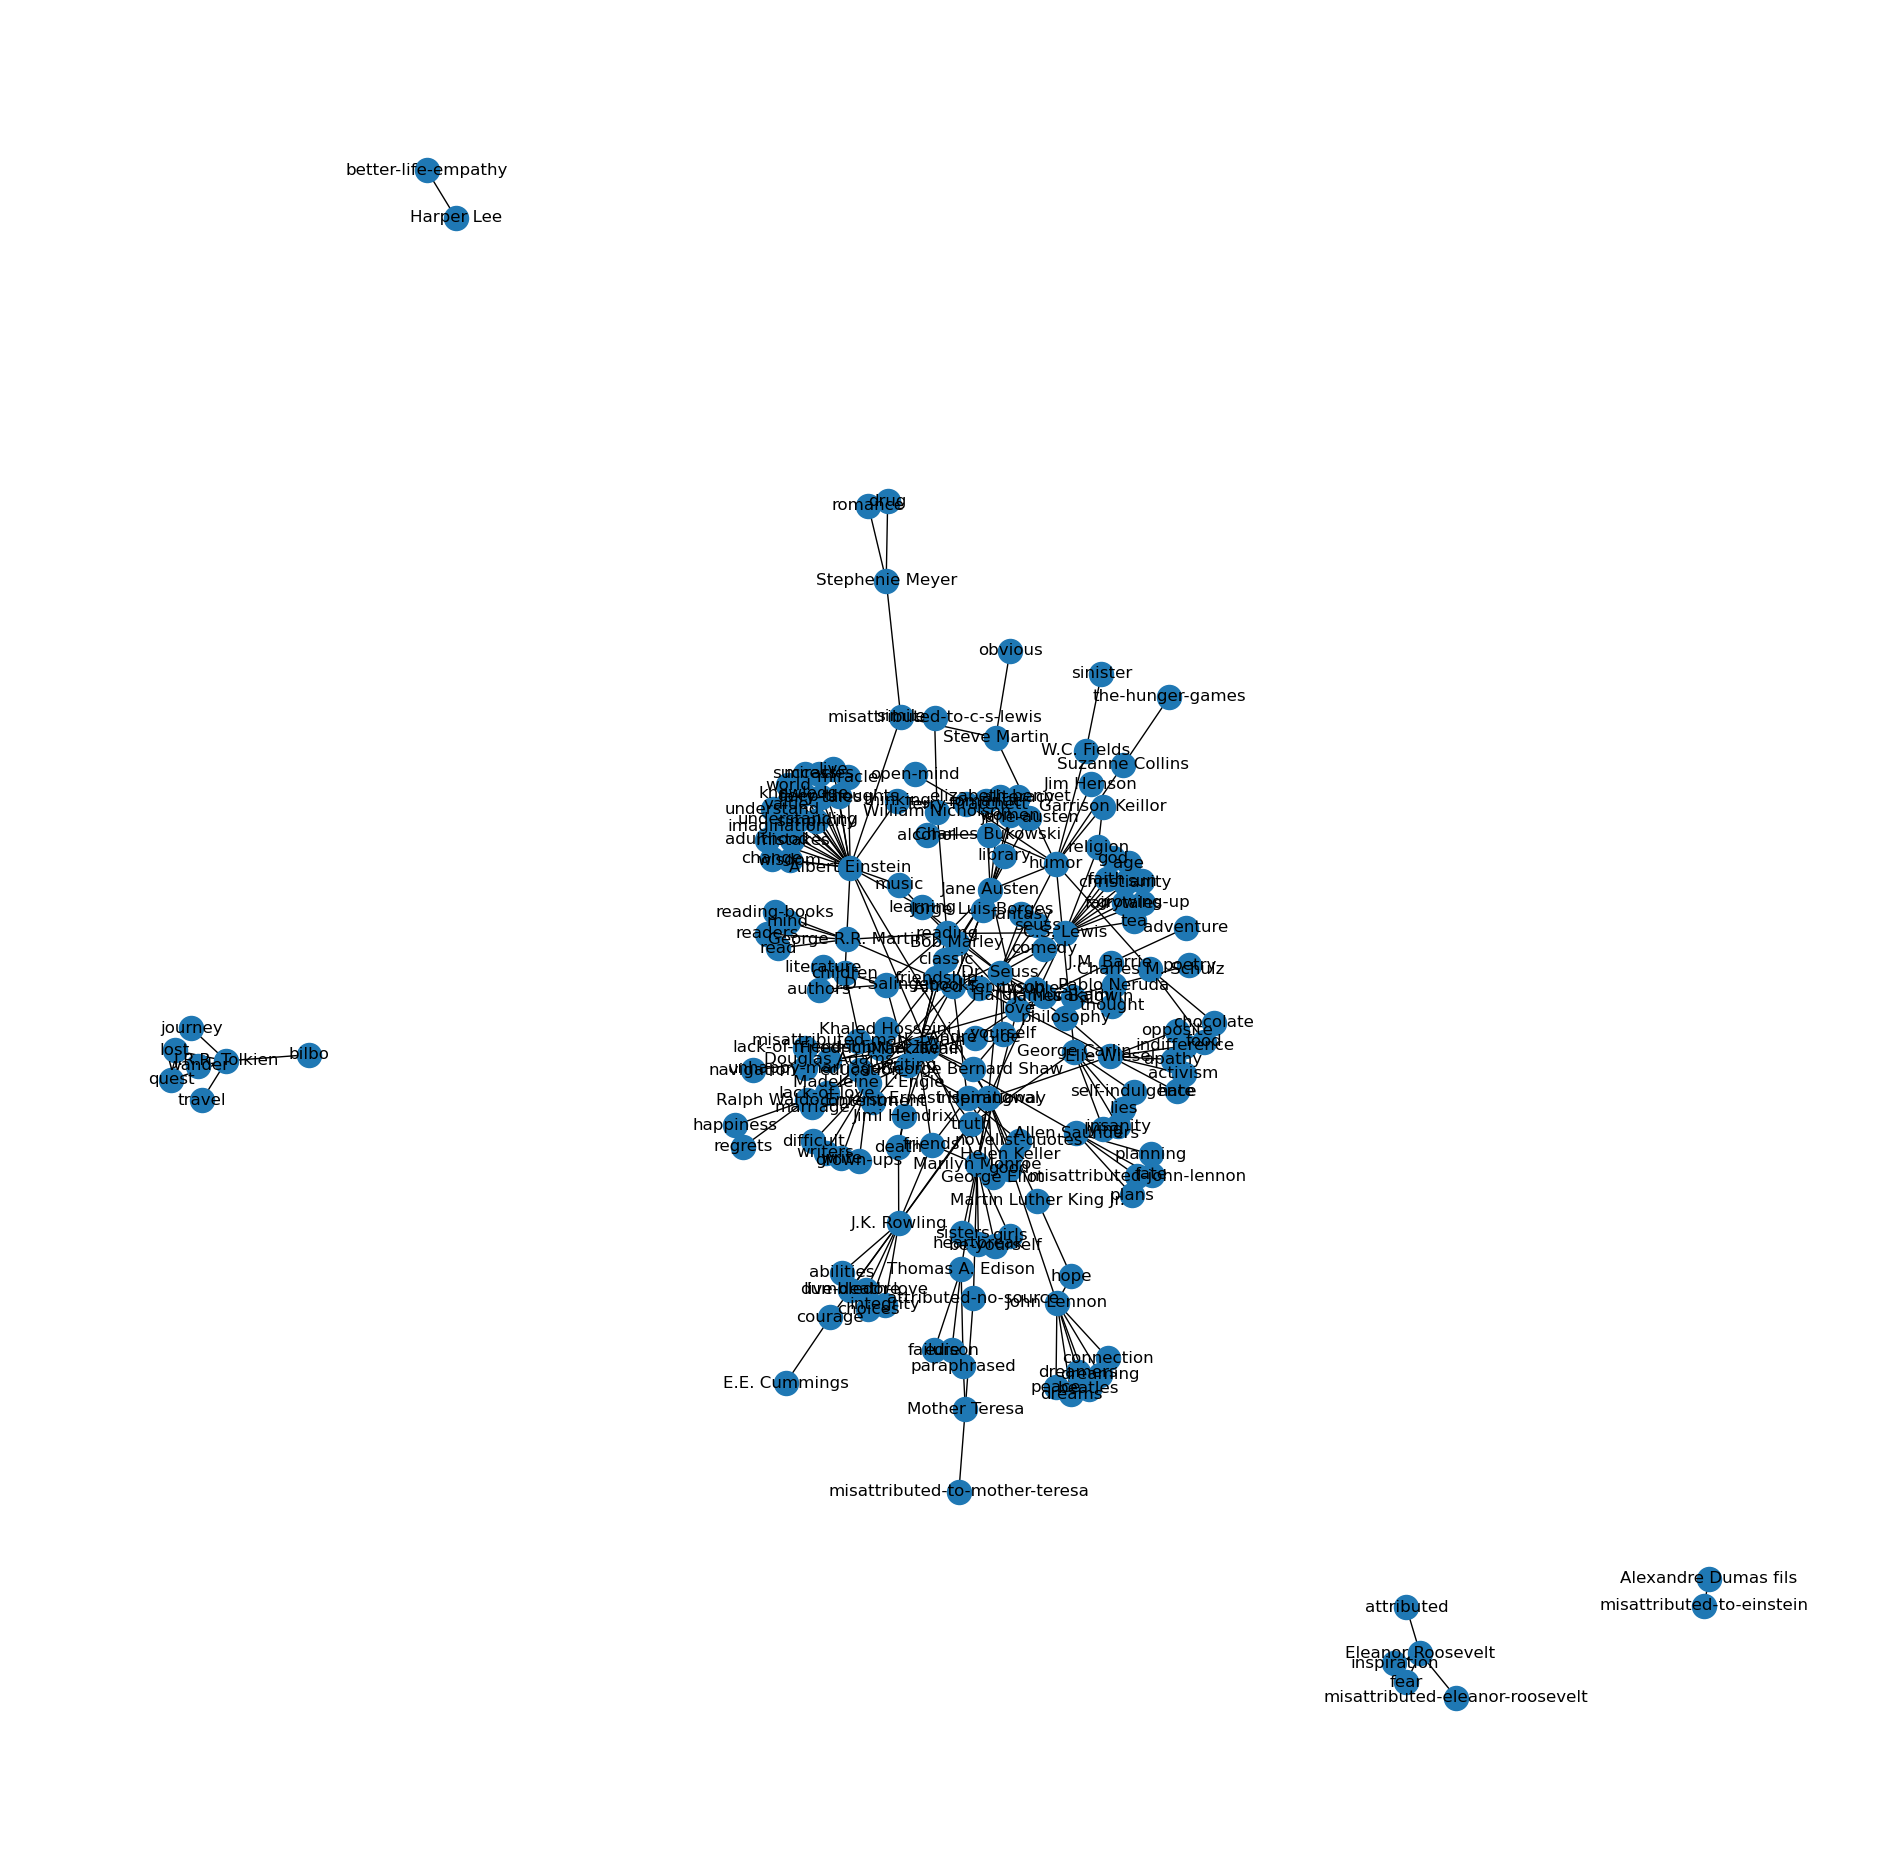

In [14]:
# read from scraped data file
# your code here
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

df = pd.read_json('quotes_P.jl', lines=True)
# organize the data such that corresponding tags and authors are connected
# your code here
authors_tags = {}
for i, data in df.iterrows():
    author = data.get('author')
    tags = data.get('tags',[])
    
    if author not in authors_tags:
        authors_tags[author] = tags
    else:
        for tag in tags:
            if tag not in authors_tags[author]:
                authors_tags[author].append(tag)
# visualize the data
# your code here
G = nx.Graph()
for author, tags in authors_tags.items():
    for tag in tags:
        G.add_edge(author, tag)

fig, ax = plt.subplots()
fig.set_figwidth(24)
fig.set_figheight(24)
nx.draw(G, ax=ax, with_labels=True)